# Unsupervised federated learning: K-means clustering

The present notebook tackles the problem of *unsupervised* learning in a federated configuration. 
In particular, a K-Means clustering is used from the `sklearn` library (see [this link](https://scikit-learn.org/stable/modules/clustering.html#k-means)).

The framework provides som functions to load the [Iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset.

Using TensorFlow backend.
No handles with labels found to put in legend.


(135, 4)
(15, 4)


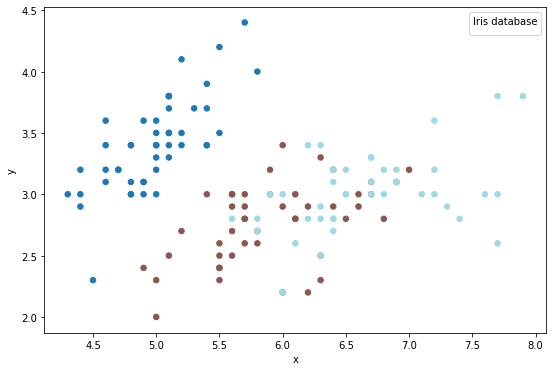

In [1]:
import matplotlib.pyplot as plt
import shfl
import numpy as np
from shfl.data_base.iris import Iris


# Assign database:    
database = Iris()

train_data, train_labels, test_data, test_labels = database.load_data()
print(train_data.shape)
print(test_data.shape)

# Visualize train data: 
fig, ax = plt.subplots(figsize=(9,6))
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=30, cmap="tab20")
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(title = "Iris database")
plt.show()

We implement method to plot K-Means results in Iris database and establish a centralised model which we will compare with. 

[[4.98297872 3.40851064 1.45531915 0.24042553]
 [6.86       3.09714286 5.69142857 2.05142857]
 [5.87924528 2.74339623 4.33207547 1.40754717]]


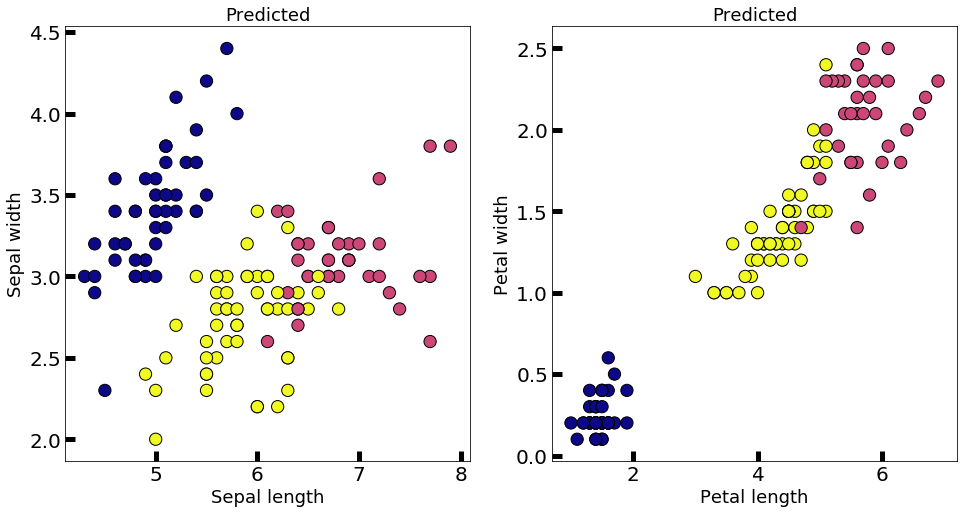

In [2]:
from shfl.model.kmeans_model import KMeansModel

def plot_k_means(km, X, title):
    new_labels = km.predict(X)
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    axes[0].scatter(X[:, 0], X[:, 1], c=new_labels, cmap='plasma',
    edgecolor='k', s=150)
    axes[1].scatter(X[:, 2], X[:, 3], c=new_labels, cmap='plasma',
    edgecolor='k', s=150)
    axes[0].set_xlabel('Sepal length', fontsize=18)
    axes[0].set_ylabel('Sepal width', fontsize=18)
    axes[1].set_xlabel('Petal length', fontsize=18)
    axes[1].set_ylabel('Petal width', fontsize=18)
    axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
    axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
    axes[0].set_title('Predicted', fontsize=18)
    axes[1].set_title('Predicted', fontsize=18)
    
# Plot train data:
model_centralized = KMeansModel(n_clusters=3, init = np.zeros((3,4)))
model_centralized.train(train_data)
print(model_centralized.get_model_params())
plot_k_means(model_centralized, train_data, title = "Benchmark: K-means using Centralized data")

**How to aggregate model's parameters from each federated node in clustering** <br/>

Since the labels of clusters can vary among each node, we cannot average the centroids right away. 
A solution is to choose the lowest distance average: this is achieved by simply applying the k-means algorithm on the centroids coordinates of all nodes. 
In [ClusterFedAvgAggregator](../shfl/federated_aggregator/cluster_fedavg_aggregator.py) you can see its implementation.

**Remark**: this implementation is based on the assumption that the number of clusters is previously fixed across the clients, so it only works properly in I.I.D scenarios (see [Federated Sampling](./federated_sampling.ipynb)). We are working in a federated aggregation operator which works in every distribution of data across clients.

In [3]:
from shfl.federated_aggregator.cluster_fedavg_aggregator import ClusterFedAvgAggregator

# Create the IID data: 
iid_distribution = shfl.data_distribution.IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes = 12, percent=100)
print("Number of nodes: " + str(federated_data.num_nodes()))

# Run the algorithm:
aggregator = ClusterFedAvgAggregator()

Number of nodes: 12


We are now ready to run our model in a federated configuration. 

The performance is assessed by several clustering metrics (see [this link](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)).

For reference, below we compare the metrics of:
 - Each node; 
 - The global (federated) model;
 - The centralized (non-federated) model.
 
It can be observed that the performance of *Global federated model* is in general superior with respect to the performance of each node, thus the federated learning approach proves to be beneficial. Moreover, the performance of the Global federated model is very close to the performance of the centralized model.

Test data size: 15


Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a2d81e110>: (0.591747891090701, 0.6287018144303527, 0.6096653899477558, 0.291497975708502)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a2d81eb90>: (0.5238905667611815, 0.7246855564996443, 0.6081422187166576, 0.3533345064226641)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a2d81e910>: (0.5050954010225338, 0.5923801385612613, 0.5452667924751302, 0.37823834196891193)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a2d81e7d0>: (0.5555979293662768, 0.6516099289679765, 0.5997859023029557, 0.3005181347150259)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a2d827cd0>: (0.6338416614218602, 0.6338416614218602, 0.6338416614218602, 0.3322734499205087)
Test performance client <shfl.private.federated_opera

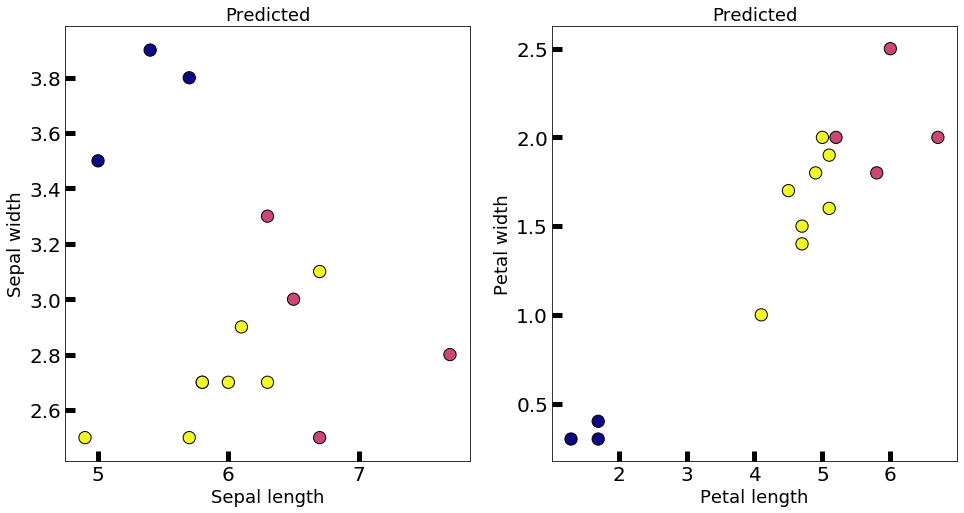

In [4]:
from shfl.learning_approach.federated_government import FederatedGovernment

n_clusters = 3 # Set number of clusters
def model_builder():
    model = KMeansModel(n_clusters=n_clusters, init = np.zeros((n_clusters,4)))
    return model


federated_government = FederatedGovernment(model_builder, federated_data, aggregator)
print("Test data size: " + str(test_data.shape[0]))
print("\n")
federated_government.run_rounds(n = 3, test_data = test_data, test_label = test_label)

# Reference Centralized (non federate) model:
print("Centralized model test performance : " + str(model_centralized.evaluate(data=test_data, labels=test_labels)))
plot_k_means(model_centralized, test_data, title = "Benchmark on Test data: K-means using CENTRALIZED data")